In [7]:
import pandas as pd
import ast
from tqdm import tqdm
#!pip install tweetnlp
import tweetnlp
from perspective import PerspectiveAPI

import seaborn as sns
import matplotlib.pyplot as plt
import scipy

In [8]:
def get_frame_wise_sentiments(df):
    finer_counts_positive = {}
    finer_counts_negative= {}
    finer_counts_neutral = {}
    finer_counts_toxicity = {}
    
    for idx, row in df.iterrows():
        clean = ast.literal_eval(row['finer_updated'])
        sentiment_positive = row['sentiment_positive']
        sentiment_negative = row['sentiment_negative']
        sentiment_neutral = row['sentiment_neutral']
        toxicity = row['toxicity']
            
        for lab in clean:
            if lab not in finer_counts_positive:
                finer_counts_positive[lab] = []
            if lab not in finer_counts_negative:
                finer_counts_negative[lab] = []
            if lab not in finer_counts_neutral:
                finer_counts_neutral[lab] = []
            if lab not in finer_counts_toxicity:
                finer_counts_toxicity[lab] = []
                       
            finer_counts_positive[lab].append(sentiment_positive)
            finer_counts_negative[lab].append(sentiment_negative)
            finer_counts_neutral[lab].append(sentiment_neutral)
            finer_counts_toxicity[lab].append(toxicity)
            
    return finer_counts_positive, finer_counts_negative, finer_counts_neutral, finer_counts_toxicity
    
    
def get_inverse_frame_wise_sentiments(df):
    # for every frame, get the distribution of all the tweets that dont contain that frame 
    
    finer_counts_positive = {}
    finer_counts_negative= {}
    finer_counts_neutral = {}
    finer_counts_toxicity = {}
    orig_counts = {}
    
    for idx, row in df.iterrows():
        #clean = row['finer_updated']
        clean = ast.literal_eval(row['finer_updated'])
            
        for lab in clean:
            if lab not in orig_counts:
                orig_counts[lab] = 0
            orig_counts[lab] +=1
    print(orig_counts)
            
    
    # iterate over each frame, append scores for each post that does not contain that frame
    order = ['government_critique', 'money_aid_resource_allocation', 'societal_critique', 'solutions_interventions',
       'personal_interaction_observation_of_homelessness', 'media_portrayal', 'not_in_my_backyard', 'deserving_undeserving_of_resources',
       'harmful_generalization']
    
    for frame in order:
        if frame not in finer_counts_positive:
            finer_counts_positive[frame] = []
        if frame not in finer_counts_negative:
            finer_counts_negative[frame] = []
        if frame not in finer_counts_neutral:
            finer_counts_neutral[frame] = []
        if frame not in finer_counts_toxicity:
            finer_counts_toxicity[frame] = []
            
        for idx, row in df.iterrows():
            clean = ast.literal_eval(row['finer_updated'])
            
            if frame not in clean:
                sentiment_positive = row['sentiment_positive']
                sentiment_negative = row['sentiment_negative']
                sentiment_neutral = row['sentiment_neutral']
                toxicity = row['toxicity']
                
                finer_counts_positive[frame].append(sentiment_positive)
                finer_counts_negative[frame].append(sentiment_negative)
                finer_counts_neutral[frame].append(sentiment_neutral)
                finer_counts_toxicity[frame].append(toxicity)
                
            if len(finer_counts_positive[frame]) > orig_counts[frame]:
                break
                
        
    return finer_counts_positive, finer_counts_negative, finer_counts_neutral, finer_counts_toxicity
    
def get_frame_wise_tweets(df):
    finer_counts = {}
    
    for idx, row in df.iterrows():
        clean = row['finer_updated']
        tweet = row['tweet_processed']
            
        for lab in clean:
            if lab not in finer_counts:
                finer_counts[lab] = []
            finer_counts[lab].append(tweet)
        
    return finer_counts

In [9]:
KEY='PERSPECTIVE_API_KEY'
p = PerspectiveAPI(KEY)
model = tweetnlp.load_model('sentiment')


def extract_sentiment_toxicity(path):
    '''
    Run this function to extract sentiment and toxicity scores given human annotations
    
    :path (str) path to human_annotations
    '''

    #path = 'analysis_data/expert_annotations.csv'
    anns = pd.read_csv(path)

    flags = []
    for idx, row in anns.iterrows():
        finer = ast.literal_eval(row['finer_updated'])
        if len(finer) == 0 or '0' in finer or finer=='[]':
            flags.append(False)
        else:
            flags.append(True)
    expert_anns = anns[flags]
    expert_anns.reset_index()

    expert_anns['sentiment_positive'] = expert_anns['Input.tweet1']\
    .apply(lambda x: model.sentiment(x, return_probability=True)['probability']['positive'])

    expert_anns['sentiment_negative'] = expert_anns['Input.tweet1']\
    .apply(lambda x: model.sentiment(x, return_probability=True)['probability']['negative'])


    expert_anns['sentiment_neutral'] = expert_anns['Input.tweet1']\
    .apply(lambda x: model.sentiment(x, return_probability=True)['probability']['neutral'])


    toxicity = []
    for idx, row in tqdm(expert_anns.iterrows(), total=expert_anns.shape[0]):
        try:
            tox = p.score(row['Input.tweet1'])["TOXICITY"]
            toxicity.append(tox)
        except:
            toxicity.append(0.0)

    expert_anns['toxicity'] = toxicity
    expert_anns.to_csv("analysis_data/expert_annotations_toxicity_sentiment.csv")
    
    return expert_anns

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/jaspreet/.conda/envs/lxmert/lib/python3.9/site-packages/torch/cuda/__init__.py:141: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11000). Please update your GPU driver by downloading and installing a new version from the URL: http:/

In [3]:
expert_sent_tox = pd.read_csv("analysis_data/expert_annotations_toxicity_sentiment.csv") # this file contains sentiment and toxicity scores for human annotations 

# path = 'analysis_data/expert_annotations.csv'
# expert_sent_tox = extract_sentiment_toxicity(path) # given human annotations, extract sentiment and toxicity scores 


In [10]:
# get stats for plotting 
dic_positive, dic_negative, dic_neutral, dic_toxicity = get_frame_wise_sentiments(expert_sent_tox)
dic_positive_inverse, dic_negative_inverse, dic_neutral_inverse, dic_toxicity_inverse = get_inverse_frame_wise_sentiments(expert_sent_tox)




{'solutions_interventions': 1261, 'money_aid_resource_allocation': 474, 'deserving_undeserving_of_resources': 411, 'harmful_generalization': 1358, 'societal_critique': 918, 'government_critique': 1040, 'media_portrayal': 119, 'personal_interaction_observation_of_homelessness': 646, 'not_in_my_backyard': 146}


# Sentiment

solutions_interventions
solutions_interventions
money_aid_resource_allocation
money_aid_resource_allocation
deserving_undeserving_of_resources
deserving_undeserving_of_resources
harmful_generalization
harmful_generalization
societal_critique
societal_critique
government_critique
government_critique
media_portrayal
media_portrayal
personal_interaction_observation_of_homelessness
personal_interaction_observation_of_homelessness
not_in_my_backyard
not_in_my_backyard


<Figure size 12000x10000 with 0 Axes>

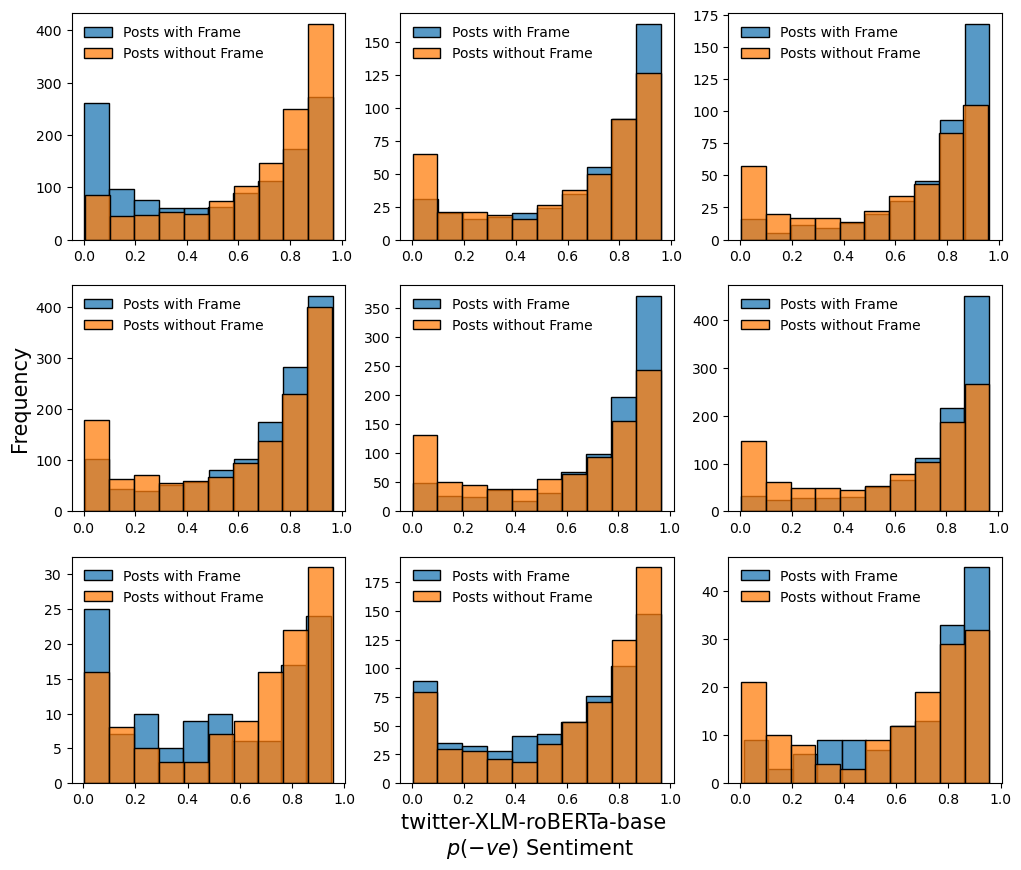

In [11]:
# Define a custom color palette with aesthetically pleasing colors
custom_palette = ['#1f77b4', '#ff7f0e']  # Blue


plt.rcParams["figure.figsize"] = (12,10)
plt.figure(dpi=1000)


n_cols=3
n_rows=3
column_names = list(dic_negative.keys())
dist_data = [[dic_negative[column], dic_negative_inverse[column]] for column in column_names]
dist_labels = ['Posts with Frame', 'Posts without Frame']


# Create the subplots
fig, axes = plt.subplots(nrows=3, ncols=3)
harmgen_dist = []

for i, (column, data) in enumerate(zip(column_names, dist_data)):
    for j, (distribution, label, color) in enumerate(zip(data, dist_labels, custom_palette)):
        sns.histplot(distribution, ax=axes[i//n_cols, i%n_cols], color=color, label=label, bins=10)
        print(column)
        if column == 'harmful_generalization':
            harmgen_dist.append(distribution)
        
    axes[i//n_cols, i%n_cols].set_ylabel("")    # remove y label       
    axes[i//n_cols, i%n_cols].legend(title="", loc='upper left', frameon=False)  # add legend and set frameon=False

    plt.yticks(fontsize=10)    # remove y label       
axes[2,1].set_xlabel("twitter-XLM-roBERTa-base \n $p(-ve)$ Sentiment", fontsize=15)
axes[1,0].set_ylabel("Frequency", fontsize=15)

# plt.savefig("sentiment_neg.pdf",bbox_inches='tight')


plt.show()

## Significance Testing

In [12]:

scipy.stats.ttest_ind(harmgen_dist[0], harmgen_dist[1])

Ttest_indResult(statistic=5.772093806184218, pvalue=8.716998228425715e-09)

# Toxicity

<Figure size 12000x10000 with 0 Axes>

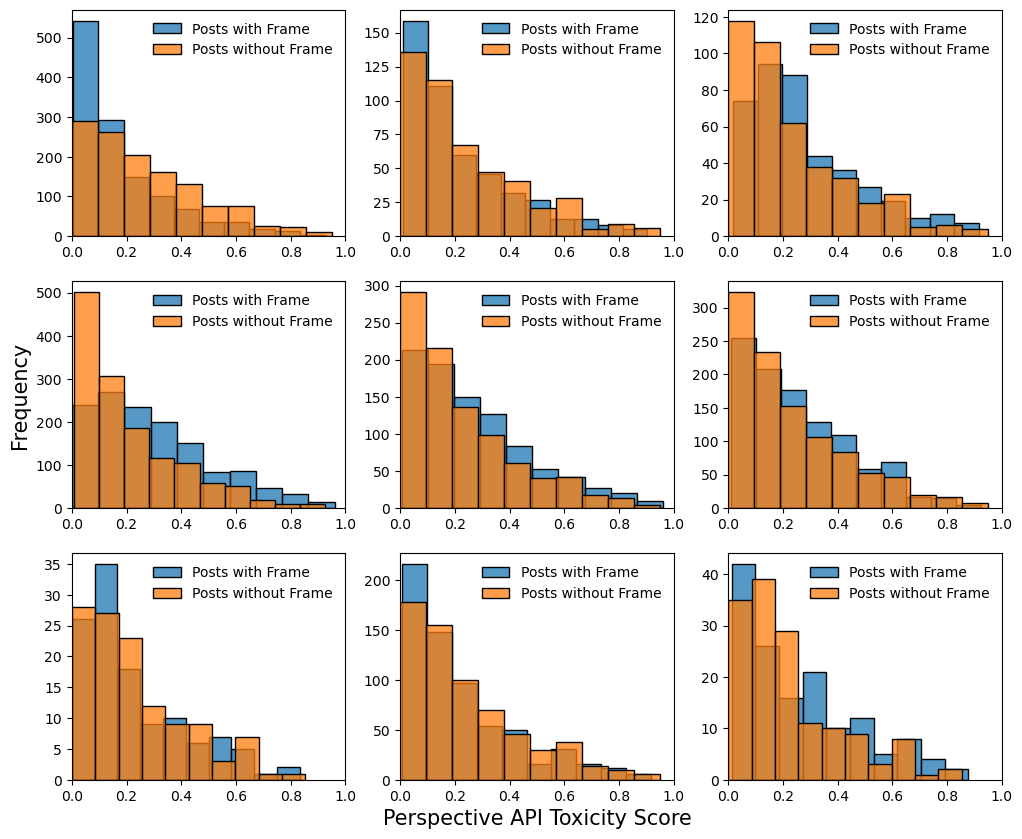

In [13]:
# Define a custom color palette with aesthetically pleasing colors
custom_palette = ['#1f77b4', '#ff7f0e']  # Blue


plt.rcParams["figure.figsize"] = (12,10)
plt.figure(dpi=1000)


n_cols=3
n_rows=3
column_names = list(dic_toxicity.keys())
dist_data = [[dic_toxicity[column], dic_toxicity_inverse[column]] for column in column_names]
dist_labels = ['Posts with Frame', 'Posts without Frame']
# Create the subplots
fig, axes = plt.subplots(nrows=3, ncols=3)

for i, (column, data) in enumerate(zip(column_names, dist_data)):
    for j, (distribution, label, color) in enumerate(zip(data, dist_labels, custom_palette)):
        sns.histplot(distribution, ax=axes[i//n_cols, i%n_cols], color=color, label=label, bins=10)
        
    axes[i//n_cols, i%n_cols].set_ylabel("")    # remove y label       
    axes[i//n_cols, i%n_cols].set_xlim(0, 1)    # set x limit
    axes[i//n_cols, i%n_cols].legend(title="", loc='upper right', frameon=False)  # add legend and set frameon=False

    plt.yticks(fontsize=10)    # remove y label       
axes[2,1].set_xlabel("Perspective API Toxicity Score", fontsize=15)
axes[1,0].set_ylabel("Frequency", fontsize=15)

# plt.savefig("toxicity_score.pdf",bbox_inches='tight')

plt.show()